# Introduction

### Implemented Recurrent Neural Network based Model owing to it's Time Series like data.
 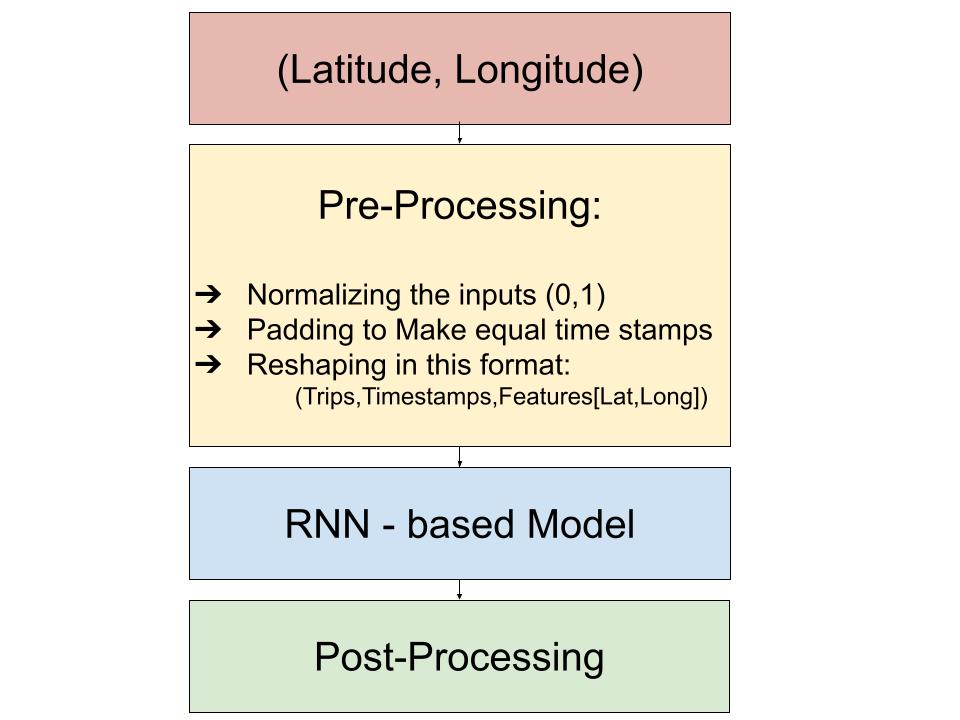



## This Notebook involves :
###  Data pre-processing
1. Normalizing the inputs for the model
2. Padding (For equal timestamps)
3. Reshaping in (Trips,Timestamps,[Lat,Long]) format

### Training
 - Building the Model using Keras
 - Training (Make sure to enable GPU)
 - Prediction
  
### Post-processing 
 - De-Normalizing
 - Submission
 
### Conclusion
 - When you train it you'll see that the model doesn't perform well due to overfitting.
 - There is very less data to train. Hence doesn't generalize well


#### Check if GPU is available or not

In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

2022-06-04 13:57:44.410641: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-04 13:57:44.474706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 13:57:44.610212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 13:57:44.611113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

True

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 13:57:46.808372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 13:57:46.809514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 15403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


#### Imports

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px

pd.set_option("max_columns", 500)

In [3]:
!pip install nb_black > /dev/null
%load_ext lab_black

# Convert raw data to gps
Ref: [GSDC2 - baseline submission
](https://www.kaggle.com/code/saitodevel01/gsdc2-baseline-submission)

In [4]:
import glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline

INPUT_PATH = "../input/smartphone-decimeter-2022"

WGS84_SEMI_MAJOR_AXIS = 6378137.0
WGS84_SEMI_MINOR_AXIS = 6356752.314245
WGS84_SQUARED_FIRST_ECCENTRICITY = 6.69437999013e-3
WGS84_SQUARED_SECOND_ECCENTRICITY = 6.73949674226e-3

HAVERSINE_RADIUS = 6_371_000


@dataclass
class ECEF:
    x: np.array
    y: np.array
    z: np.array

    def to_numpy(self):
        return np.stack([self.x, self.y, self.z], axis=0)

    @staticmethod
    def from_numpy(pos):
        x, y, z = [np.squeeze(w) for w in np.split(pos, 3, axis=-1)]
        return ECEF(x=x, y=y, z=z)


@dataclass
class BLH:
    lat: np.array
    lng: np.array
    hgt: np.array


def ECEF_to_BLH(ecef):
    a = WGS84_SEMI_MAJOR_AXIS
    b = WGS84_SEMI_MINOR_AXIS
    e2 = WGS84_SQUARED_FIRST_ECCENTRICITY
    e2_ = WGS84_SQUARED_SECOND_ECCENTRICITY
    x = ecef.x
    y = ecef.y
    z = ecef.z
    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(z * (a / b), r)
    B = np.arctan2(z + (e2_ * b) * np.sin(t) ** 3, r - (e2 * a) * np.cos(t) ** 3)
    L = np.arctan2(y, x)
    n = a / np.sqrt(1 - e2 * np.sin(B) ** 2)
    H = (r / np.cos(B)) - n
    return BLH(lat=B, lng=L, hgt=H)


def haversine_distance(blh_1, blh_2):
    dlat = blh_2.lat - blh_1.lat
    dlng = blh_2.lng - blh_1.lng
    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(blh_1.lat) * np.cos(blh_2.lat) * np.sin(dlng / 2) ** 2
    )
    dist = 2 * HAVERSINE_RADIUS * np.arcsin(np.sqrt(a))
    return dist


def pandas_haversine_distance(df1, df2):
    blh1 = BLH(
        lat=np.deg2rad(df1["LatitudeDegrees"].to_numpy()),
        lng=np.deg2rad(df1["LongitudeDegrees"].to_numpy()),
        hgt=0,
    )
    blh2 = BLH(
        lat=np.deg2rad(df2["LatitudeDegrees"].to_numpy()),
        lng=np.deg2rad(df2["LongitudeDegrees"].to_numpy()),
        hgt=0,
    )
    return haversine_distance(blh1, blh2)


def ecef_to_lat_lng(tripID, gnss_df, UnixTimeMillis):
    ecef_columns = [
        "WlsPositionXEcefMeters",
        "WlsPositionYEcefMeters",
        "WlsPositionZEcefMeters",
    ]
    columns = ["utcTimeMillis"] + ecef_columns
    ecef_df = (
        gnss_df.drop_duplicates(subset="utcTimeMillis")[columns]
        .dropna()
        .reset_index(drop=True)
    )
    ecef = ECEF.from_numpy(ecef_df[ecef_columns].to_numpy())
    blh = ECEF_to_BLH(ecef)

    TIME = ecef_df["utcTimeMillis"].to_numpy()
    lat = InterpolatedUnivariateSpline(TIME, blh.lat, ext=3)(UnixTimeMillis)
    lng = InterpolatedUnivariateSpline(TIME, blh.lng, ext=3)(UnixTimeMillis)
    return pd.DataFrame(
        {
            "tripId": tripID,
            "UnixTimeMillis": UnixTimeMillis,
            "LatitudeDegrees": np.degrees(lat),
            "LongitudeDegrees": np.degrees(lng),
        }
    )


def calc_score(tripID, pred_df, gt_df):
    d = pandas_haversine_distance(pred_df, gt_df)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])
    return score

Ref: [📱 Smartphone Competition 2022 [Twitch Stream]](https://www.kaggle.com/code/robikscube/smartphone-competition-2022-twitch-stream)

In [5]:
import glob

INPUT_PATH = "../input/smartphone-decimeter-2022"

sample_df = pd.read_csv(f"{INPUT_PATH}/sample_submission.csv")
# print(sample_df)
pred_dfs = []
for dirname in tqdm(sorted(glob.glob(f"{INPUT_PATH}/test/*/*"))):
    drive, phone = dirname.split("/")[-2:]
    tripID = f"{drive}/{phone}"
    gnss_df = pd.read_csv(f"{dirname}/device_gnss.csv")
    UnixTimeMillis = sample_df[sample_df["tripId"] == tripID][
        "UnixTimeMillis"
    ].to_numpy()
    pred_dfs.append(ecef_to_lat_lng(tripID, gnss_df, UnixTimeMillis))
sub_df = pd.concat(pred_dfs)

baselines = []
gts = []
for dirname in tqdm(sorted(glob.glob(f"{INPUT_PATH}/train/*/*"))):
    drive, phone = dirname.split("/")[-2:]
    tripID = f"{drive}/{phone}"
    gnss_df = pd.read_csv(f"{dirname}/device_gnss.csv", low_memory=False)
    gt_df = pd.read_csv(f"{dirname}/ground_truth.csv", low_memory=False)
    baseline_df = ecef_to_lat_lng(tripID, gnss_df, gt_df["UnixTimeMillis"].to_numpy())
    baselines.append(baseline_df)
    gt_df["tripId"] = tripID
    gts.append(gt_df)
baselines = pd.concat(baselines)
print(baselines)
gts = pd.concat(gts)
print(gts)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

                                  tripId  UnixTimeMillis  LatitudeDegrees  \
0     2020-05-15-US-MTV-1/GooglePixel4XL   1589573679445        37.416664   
1     2020-05-15-US-MTV-1/GooglePixel4XL   1589573680445        37.416576   
2     2020-05-15-US-MTV-1/GooglePixel4XL   1589573681445        37.416519   
3     2020-05-15-US-MTV-1/GooglePixel4XL   1589573682445        37.416542   
4     2020-05-15-US-MTV-1/GooglePixel4XL   1589573683445        37.416538   
...                                  ...             ...              ...   
1609       2021-12-28-US-MTV-1/XiaomiMi8   1640724240000        37.416021   
1610       2021-12-28-US-MTV-1/XiaomiMi8   1640724241000        37.416016   
1611       2021-12-28-US-MTV-1/XiaomiMi8   1640724242000        37.416027   
1612       2021-12-28-US-MTV-1/XiaomiMi8   1640724243000        37.416036   
1613       2021-12-28-US-MTV-1/XiaomiMi8   1640724244000        37.416031   

      LongitudeDegrees  
0          -122.082013  
1          -122.082059  


In [6]:
ss = pd.read_csv("../input/smartphone-decimeter-2022/sample_submission.csv")

In [7]:
baselines["group"] = "train_baseline"
sub_df["group"] = "submission_baseline"
gts["group"] = "train_ground_truth"
combined = pd.concat([baselines, sub_df]).reset_index(drop=True).copy()

In [8]:
Lat = combined["LatitudeDegrees"].to_numpy()
Long = combined["LongitudeDegrees"].to_numpy()

In [9]:
Lat_gt = gts["LatitudeDegrees"].to_numpy()
Long_gt = gts["LongitudeDegrees"].to_numpy()

# Normalization
Bringing Data to standard form so that is makes sense in the model

In [10]:
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import sqrt

In [11]:
# Latitude

series_Lat_train = Series(Lat.flatten())

series_Lat_gt = Series(Lat_gt.flatten())

values_train = series_Lat_train.values
values_train = values_train.reshape((len(values_train), 1))

print(values_train.shape)

values_gt = series_Lat_gt.values
values_gt = values_gt.reshape((len(values_gt), 1))

# train the normalization
scaler_lat = MinMaxScaler()
scaler_lat = scaler_lat.fit(values_train)

# normalize the dataset and print
standardized_lat_train = scaler_lat.transform(values_train)
# print(standardized_lat_train)
print(standardized_lat_train.shape)

standardized_lat_gt = scaler_lat.transform(values_gt)
print(standardized_lat_gt)
# print(standardized_lat_gt.shape)

# inverse transform and print
inversed_lat_train = scaler_lat.inverse_transform(standardized_lat_train)
# print(inversed_lat_train)
inversed_lat_gt = scaler_lat.inverse_transform(standardized_lat_gt)
# print(inversed_lat_gt)

(361730, 1)
(361730, 1)
[[0.95366795]
 [0.95366795]
 [0.95366795]
 ...
 [0.95360301]
 [0.95360301]
 [0.95360301]]


In [12]:
sub_df.shape

(66097, 5)

In [13]:
standardized_lat_train = standardized_lat_train.reshape(361730)
standardized_lat_train_only = standardized_lat_train[0:295633]
baselines["standardized_lat"] = standardized_lat_train_only

standardized_lat_sub = standardized_lat_train[295633:]
ss["standardized_lat"] = standardized_lat_sub

gts["standardized_lat"] = standardized_lat_gt.reshape(295633)

In [14]:
# Long

series_Long_train = Series(Long.flatten())
# print(series_Long_train)

series_Long_gt = Series(Long_gt.flatten())
# print(series_Long_gt)

values_train_long = series_Long_train.values
values_train_long = values_train_long.reshape((len(values_train_long), 1))

print(values_train_long.shape)

values_gt_long = series_Long_gt.values
values_gt_long = values_gt_long.reshape((len(values_gt_long), 1))

# train the normalization
# scaler_long = StandardScaler()
scaler_long = MinMaxScaler()
scaler_long = scaler_long.fit(values_train_long)

# normalize the dataset and print
standardized_long_train = scaler_long.transform(values_train_long)
# print(standardized_long_train)
print(standardized_long_train.shape)

standardized_long_gt = scaler_long.transform(values_gt_long)
print(standardized_long_gt)
# print(standardized_long_gt.shape)

# inverse transform and print
inversed_long_train = scaler_long.inverse_transform(standardized_long_train)
# print(inversed_lat_train)
inversed_long_gt = scaler_long.inverse_transform(standardized_long_gt)
# print(inversed_lat_gt)

(361730, 1)
(361730, 1)
[[0.04919687]
 [0.04919687]
 [0.04919687]
 ...
 [0.04935446]
 [0.04935446]
 [0.04935446]]


In [15]:
standardized_long_train = standardized_long_train.reshape(361730)
standardized_long_train_only = standardized_long_train[0:295633]
baselines["standardized_long"] = standardized_long_train_only

standardized_long_sub = standardized_long_train[295633:]
ss["standardized_long"] = standardized_long_sub

gts["standardized_long"] = standardized_long_gt.reshape(295633)

In [16]:
gts.tail()

MessageType Provider  LatitudeDegrees  LongitudeDegrees  AltitudeMeters  \
1609         Fix       GT         37.41605        -122.08094      -26.379000   
1610         Fix       GT         37.41605        -122.08094      -26.379001   
1611         Fix       GT         37.41605        -122.08094      -26.379000   
1612         Fix       GT         37.41605        -122.08094      -26.379001   
1613         Fix       GT         37.41605        -122.08094      -26.379000   

      SpeedMps  AccuracyMeters  BearingDegrees  UnixTimeMillis  \
1609  0.006399             0.1       184.65560   1640724240000   
1610  0.005830             0.1       184.65590   1640724241000   
1611  0.004472             0.1       184.65613   1640724242000   
1612  0.003609             0.1       184.65622   1640724243000   
1613  0.004469             0.1       184.65636   1640724244000   

                             tripId               group  standardized_lat  \
1609  2021-12-28-US-MTV-1/XiaomiMi8  train_ground_truth          0.953603   
1610  2021-12-28-US-MTV-1/XiaomiMi8  train_ground_truth          0.953603   
1611  2021-12-28-US-MTV-1/XiaomiMi8  train_ground_truth          0.953603   
1612  2021-12-28-US-MTV-1/XiaomiMi8  train_ground_truth          0.953603   
1613  2021-12-28-US-MTV-1/XiaomiMi8  train_ground_truth          0.953603   

      standardized_long  
1609           0.049354  
1610           0.049354  
1611           0.049354  
1612           0.049354  
1613           0.049354

In [17]:
baselines.tail()

tripId  UnixTimeMillis  LatitudeDegrees  \
1609  2021-12-28-US-MTV-1/XiaomiMi8   1640724240000        37.416021   
1610  2021-12-28-US-MTV-1/XiaomiMi8   1640724241000        37.416016   
1611  2021-12-28-US-MTV-1/XiaomiMi8   1640724242000        37.416027   
1612  2021-12-28-US-MTV-1/XiaomiMi8   1640724243000        37.416036   
1613  2021-12-28-US-MTV-1/XiaomiMi8   1640724244000        37.416031   

      LongitudeDegrees           group  standardized_lat  standardized_long  
1609       -122.080936  train_baseline          0.953600           0.049355  
1610       -122.080935  train_baseline          0.953599           0.049355  
1611       -122.080940  train_baseline          0.953600           0.049354  
1612       -122.080944  train_baseline          0.953601           0.049354  
1613       -122.080947  train_baseline          0.953601           0.049353

In [18]:
ss.tail()

tripId  UnixTimeMillis  LatitudeDegrees  \
66092  2022-04-25-US-OAK-2/GooglePixel4   1650927742650        37.904611   
66093  2022-04-25-US-OAK-2/GooglePixel4   1650927743642        37.904611   
66094  2022-04-25-US-OAK-2/GooglePixel4   1650927744651        37.904611   
66095  2022-04-25-US-OAK-2/GooglePixel4   1650927745640        37.904611   
66096  2022-04-25-US-OAK-2/GooglePixel4   1650927746632        37.904611   

       LongitudeDegrees  standardized_lat  standardized_long  
66092        -86.481078          0.981127           0.074859  
66093        -86.481078          0.981136           0.074815  
66094        -86.481078          0.981119           0.074853  
66095        -86.481078          0.981139           0.074855  
66096        -86.481078          0.981114           0.074891

# Reshaping the Data and Padding
(If you have any doubts related to this ask me in the comments.)

In [19]:
max_length = np.amax(baselines["tripId"].value_counts())
desired_rows = max_length
desired_cols = 2
count = 0
for trip in baselines.tripId.unique():
    if count == 0:
        oneTrip = baselines.loc[
            (baselines["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]

        oneTrip = oneTrip.to_numpy()
        trainingPadded0 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        count = 1
    elif count == 1:
        oneTrip = baselines.loc[
            (baselines["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        trainingPadded1 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        trainingPadded = np.stack((trainingPadded0, trainingPadded1))
        count = 2
    else:
        oneTrip = baselines.loc[
            (baselines["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        oneTripPadded = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )

        # print(oneTrip.shape)
        # print(oneTripPadded.shape)
        trainingPadded = np.append(trainingPadded, [oneTripPadded], axis=0)

print(trainingPadded.shape)

(170, 3362, 2)


In [20]:
max_length = np.amax(gts["tripId"].value_counts())
desired_rows = max_length
desired_cols = 2
count = 0
for trip in gts.tripId.unique():
    if count == 0:
        oneTrip = gts.loc[
            (gts["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]

        oneTrip = oneTrip.to_numpy()
        gtsPadded0 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        count = 1
    elif count == 1:
        oneTrip = gts.loc[
            (gts["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        gtsPadded1 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        gtsPadded = np.stack((gtsPadded0, gtsPadded1))
        count = 2
    else:
        oneTrip = gts.loc[
            (gts["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        oneTripPadded = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )

        # print(oneTrip.shape)
        # print(oneTripPadded.shape)
        gtsPadded = np.append(gtsPadded, [oneTripPadded], axis=0)

print(gtsPadded.shape)

(170, 3362, 2)


In [21]:
max_length = np.amax(ss["tripId"].value_counts())
desired_rows = max_length
desired_cols = 2
count = 0
for trip in ss.tripId.unique():
    if count == 0:
        oneTrip = ss.loc[
            (ss["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]

        oneTrip = oneTrip.to_numpy()
        ssPadded0 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        count = 1
    elif count == 1:
        oneTrip = ss.loc[
            (ss["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        ssPadded1 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        ssPadded = np.stack((ssPadded0, ssPadded1))
        count = 2
    else:
        oneTrip = ss.loc[
            (ss["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        oneTripPadded = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )

        # print(oneTrip.shape)
        # print(oneTripPadded.shape)
        ssPadded = np.append(ssPadded, [oneTripPadded], axis=0)

print(ssPadded.shape)

(36, 4514, 2)


# Training

In [22]:
from keras.models import Sequential
from keras.models import Model

from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.metrics import MeanSquaredError
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Masking, Bidirectional

from keras.models import Input

In [23]:
number_of_features = 2
batch_size = 170
time_steps = 3362

input = Input(shape=(None, number_of_features))

masking = Masking(mask_value=0.0)(input)

Bidirectional_1 = Bidirectional(
    LSTM(number_of_features, return_sequences=True), merge_mode="sum"
)(masking)

Dropout_1 = Dropout(0.2)(Bidirectional_1)

out = Dense(number_of_features, activation="sigmoid")(Dropout_1)

model = Model(inputs=input, outputs=out)
model.compile(
    loss="MeanSquaredError",
    optimizer=Adam(lr=0.0003, decay=1e-3),
    metrics=["MeanSquaredError"],
)

model.summary()

2022-06-04 14:01:43.701240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 14:01:43.702187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 14:01:43.702863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 14:01:43.703824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 14:01:43.704624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 2)]         0         
_________________________________________________________________
masking (Masking)            (None, None, 2)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 2)           80        
_________________________________________________________________
dropout (Dropout)            (None, None, 2)           0         
_________________________________________________________________
dense (Dense)                (None, None, 2)           6         
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
model.fit(
    trainingPadded,
    gtsPadded,
    epochs=600,
    batch_size=34,
    verbose=1,
    use_multiprocessing=True,
    shuffle=True,
    validation_split=0.1,
)

2022-06-04 14:01:46.353862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/600


2022-06-04 14:01:53.387627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 [==============================] - 12s 752ms/step - loss: 0.0745 - mean_squared_error: 0.1400 - val_loss: 0.0314 - val_mean_squared_error: 0.0820
Epoch 2/600
5/5 [==============================] - 1s 177ms/step - loss: 0.0738 - mean_squared_error: 0.1387 - val_loss: 0.0311 - val_mean_squared_error: 0.0812
Epoch 3/600
5/5 [==============================] - 1s 176ms/step - loss: 0.0731 - mean_squared_error: 0.1374 - val_loss: 0.0308 - val_mean_squared_error: 0.0804
Epoch 4/600
5/5 [==============================] - 1s 186ms/step - loss: 0.0724 - mean_squared_error: 0.1361 - val_loss: 0.0305 - val_mean_squared_error: 0.0796
Epoch 5/600
5/5 [==============================] - 1s 183ms/step - loss: 0.0718 - mean_squared_error: 0.1348 - val_loss: 0.0302 - val_mean_squared_error: 0.0788
Epoch 6/600
5/5 [==============================] - 1s 172ms/step - loss: 0.0711 - mean_squared_error: 0.1335 - val_loss: 0.0299 - val_mean_squared_error: 0.0781
Epoch 7/600
5/5 [============================

#### Prediction

In [25]:
result = model.predict(trainingPadded)
print(result.shape)

(170, 3362, 2)


In [26]:
result_sub = model.predict(ssPadded)
print(ssPadded.shape)

(36, 4514, 2)


In [27]:
result_sub

array([[[0.8772045 , 0.19262324],
        [0.8875996 , 0.17440654],
        [0.8949291 , 0.16241819],
        ...,
        [0.5611427 , 0.42852035],
        [0.5611427 , 0.42852035],
        [0.5611427 , 0.42852035]],

       [[0.87760735, 0.19211687],
        [0.8880649 , 0.17380393],
        [0.89539266, 0.16181879],
        ...,
        [0.5611427 , 0.42852035],
        [0.5611427 , 0.42852035],
        [0.5611427 , 0.42852035]],

       [[0.8769295 , 0.19294658],
        [0.8872805 , 0.17478922],
        [0.8946047 , 0.1628084 ],
        ...,
        [0.5611427 , 0.42852035],
        [0.5611427 , 0.42852035],
        [0.5611427 , 0.42852035]],

       ...,

       [[0.8764855 , 0.1933317 ],
        [0.8867526 , 0.17524047],
        [0.894037  , 0.163321  ],
        ...,
        [0.5611427 , 0.42852035],
        [0.5611427 , 0.42852035],
        [0.5611427 , 0.42852035]],

       [[0.8780567 , 0.19143343],
        [0.88858163, 0.1729728 ],
        [0.895875  , 0.16104348],
        .

# Scoring 
- inverse of values 
- reshaping for calc the mean error

In [28]:
count = 0
predicted_lat = []
predicted_long = []
for trip in baselines.tripId.unique():
    timestamps = (baselines["tripId"] == trip).sum()
    for x in range(timestamps):
        predicted_lat.append(result[count][x][0])
        predicted_long.append(result[count][x][1])
    count = count + 1

In [29]:
np_predicted = np.array(predicted_lat)
series_np_predicted = Series(np_predicted.flatten())
values_np_predicted = series_np_predicted.values
values_np_predicted = values_np_predicted.reshape((len(values_np_predicted), 1))
inversed_np_predicted = scaler_lat.inverse_transform(values_np_predicted)
baselines["predicted_lat"] = inversed_np_predicted

np_predicted = np.array(predicted_long)
series_np_predicted = Series(np_predicted.flatten())
values_np_predicted = series_np_predicted.values
values_np_predicted = values_np_predicted.reshape((len(values_np_predicted), 1))
inversed_np_predicted = scaler_long.inverse_transform(values_np_predicted)
baselines["predicted_long"] = inversed_np_predicted

In [30]:
predicted_baseline = baselines[["tripId", "predicted_lat", "predicted_long"]].copy()
predicted_baseline.rename(columns={"predicted_lat": "LatitudeDegrees"}, inplace=True)
predicted_baseline.rename(columns={"predicted_long": "LongitudeDegrees"}, inplace=True)

scores = []
for tripID in predicted_baseline["tripId"].unique():
    score = calc_score(tripID, predicted_baseline, gts)
    scores.append(score)

mean_score = np.mean(scores)
print(f"mean_score = {mean_score:.3f}")

mean_score = 97674.559


# Submission

In [31]:
count = 0
predicted_lat = []
predicted_long = []
for trip in ss.tripId.unique():
    timestamps = (ss["tripId"] == trip).sum()
    for x in range(timestamps):
        predicted_lat.append(result_sub[count][x][0])
        predicted_long.append(result_sub[count][x][1])
    count = count + 1

In [32]:
np_predicted = np.array(predicted_lat)
series_np_predicted = Series(np_predicted.flatten())
values_np_predicted = series_np_predicted.values
values_np_predicted = values_np_predicted.reshape((len(values_np_predicted), 1))
inversed_np_predicted = scaler_lat.inverse_transform(values_np_predicted)
ss["LatitudeDegrees"] = inversed_np_predicted

np_predicted = np.array(predicted_long)
series_np_predicted = Series(np_predicted.flatten())
values_np_predicted = series_np_predicted.values
values_np_predicted = values_np_predicted.reshape((len(values_np_predicted), 1))
inversed_np_predicted = scaler_long.inverse_transform(values_np_predicted)
ss["LongitudeDegrees"] = inversed_np_predicted

In [33]:
ss.head()

tripId  UnixTimeMillis  LatitudeDegrees  \
0  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650832999        36.747280   
1  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650833999        36.838272   
2  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650834999        36.902435   
3  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650835999        36.944996   
4  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650836999        36.972858   

   LongitudeDegrees  standardized_lat  standardized_long  
0       -121.058403          0.951293           0.046268  
1       -121.188423          0.951296           0.046266  
2       -121.273987          0.951294           0.046264  
3       -121.328667          0.951295           0.046269  
4       -121.363625          0.951298           0.046263

In [34]:
ss.drop(["standardized_lat", "standardized_long"], axis=1, inplace=True)

In [35]:
ss.head() #updated with our predictions

tripId  UnixTimeMillis  LatitudeDegrees  \
0  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650832999        36.747280   
1  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650833999        36.838272   
2  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650834999        36.902435   
3  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650835999        36.944996   
4  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650836999        36.972858   

   LongitudeDegrees  
0       -121.058403  
1       -121.188423  
2       -121.273987  
3       -121.328667  
4       -121.363625

In [36]:
ss.reset_index(drop=True)[ss.columns].to_csv("submission.csv", index=False)